In [25]:
import pandas as pd 

df = pd.read_excel(r'E:\upwork\TIME_SERIES\data_set.xlsx')

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns 

In [26]:
df.columns

Index(['Week No.', 'Provider', 'Underlying Carrier SCAC (For NVOCC's)',
       'Operating Company (as shown I n GTN)', 'Region of ownership',
       'Sector (Segment)', 'Contracted Lane (Y/N)', 'Lane Name',
       'Commodity Type', 'Equipment Type', 'No. of 20 ft', 'No. of 40/40HC',
       'Total TEUS', 'Base Rate 20' Container', 'Base Rate 40'/40'HC/Reefer',
       'Premium Rate 20' Container', 'Premium Rate 40'/40'HC/Reefer',
       'Total Base + Premium Rate 20' Container',
       'Total Base + Premium Rate 40'/40'HC/Reefer',
       'Total Premium Cost in USD (# of equipment X Additional Cost)',
       'Country', 'Quarter', 'Year', 'Year Week', 'Weekday is 1 column',
       'Year Week Weekday', 'Origin Lane', 'Destination Lane', 'Origin Market',
       'Date'],
      dtype='object')

In [65]:
df.rename({'Total Premium Cost in USD (# of equipment X Additional Cost)': 'premium_cost'}, axis=1, inplace=True)

### Data description

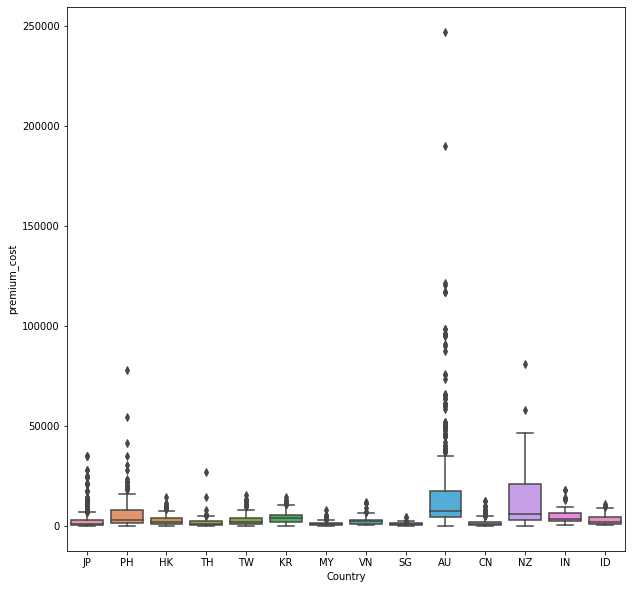

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(x="Country", y="premium_cost", data=df)

### Following this Plot we can clearly see that AU has lot of outlier values, also we can observe that there's a difference between means for each country, let use ANOVA test 

In [67]:
df.groupby('Country').mean()["premium_cost"]

Country
AU    15048.928499
CN     1745.805732
HK     2745.070707
ID     2887.700000
IN     4332.191111
JP     2676.441944
KR     4295.162698
MY     1408.491379
NZ    12319.242857
PH     5597.358280
SG     1134.607143
TH     1928.853333
TW     2638.951031
VN     2532.175258
Name: premium_cost, dtype: float64

In [68]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("premium_cost ~ Country", data= df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
Country,1.267150e+11,13.0,101.472844,1.174592e-243
Residual,5.024809e+11,5231.0,NaN,NaN


In [69]:
import scipy.stats as stats
stats.shapiro(model.resid)

c:\Users\simo-\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.5245026350021362, pvalue=0.0)

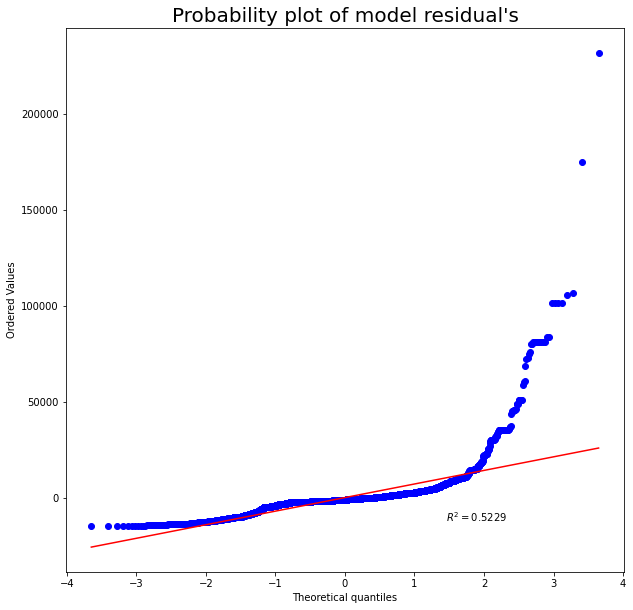

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

### ANOVA results cannot be interpreted, because of Shapiro Wilik Test and the QQ-Plot which shows that residuals is heavy-tailed
### Instead, Let use a non-parametric Test based on ranks, Kruskal Wallis similar to ANOVA use to compare medians, before doing this, variables used in the test should be discret.
### Kruksal Hypothesis : 
### - H0 : medians of all groups are equal
### - H1 : at least one population median of one group is different from the population median of at least one other group.

In [72]:
# Encoding Country variable before performing Kruksal Wallis Test 

df.Country_coded = df.Country.astype('category').cat.codes

C:\Users\simo-\AppData\Local\Temp/ipykernel_9064/2150690681.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Country_coded = df.Country.astype('category').cat.codes


In [75]:
from scipy import stats
stats.kruskal(df.Country_coded, df['premium_cost'])

KruskalResult(statistic=7847.901013708619, pvalue=0.0)

### Failed to accept H0
### As a results PUISSANCE_FISCALE is different in term of medians for each group, and we can say that Country and premium cost are not independant.

### Converting DATE format.

In [27]:
df.Date

0        Monday, February 1, 2021
1        Monday, February 1, 2021
2       Monday, February 15, 2021
3        Monday, February 1, 2021
4        Monday, February 1, 2021
                  ...            
5240    Monday, December 20, 2021
5241    Monday, December 20, 2021
5242    Monday, December 20, 2021
5243    Monday, December 27, 2021
5244    Monday, December 27, 2021
Name: Date, Length: 5245, dtype: object

In [28]:
df.groupby(['Lane Name'])['Total Premium Cost in USD (# of equipment X Additional Cost)'].sum()

Lane Name
Andernach To Sydney          9500
Antwerp To Manila            2500
Antwerp To Sydney           40729
Bangkok To Busan            28400
Bangkok To Jakarta            980
                            ...  
Wuppertal To Keelung         1300
Wuppertal To Nhava Sheva    13154
Wuppertal To Shanghai       29935
Wuppertal To Sydney         65299
Yokohama To Jakarta          5050
Name: Total Premium Cost in USD (# of equipment X Additional Cost), Length: 148, dtype: int64

In [31]:
def get_date(x):
    months={"January":"01","February":"02","March":"03","April":"04",   "May":"05","June":"06","July":"07","August":"08","September":"09", "October":"10", "November":"11","December":"12",}
    tokens = x.split(" ")
    # month
    month = months[tokens[1]]
    # day
    day=tokens[2]
    if(len(day)==1):
        day="0"+day
    
    # year
    year = x.split(" ")[3]
    
    return (day+"-"+month+"-"+year).replace(',','')

In [34]:
df.Date = df.Date.apply(get_date)

In [38]:
test_data = df[['Total Premium Cost in USD (# of equipment X Additional Cost)','Date']]

In [47]:
test_data = pd.DataFrame(test_data.groupby('Date')['Total Premium Cost in USD (# of equipment X Additional Cost)'].sum()).reset_index()

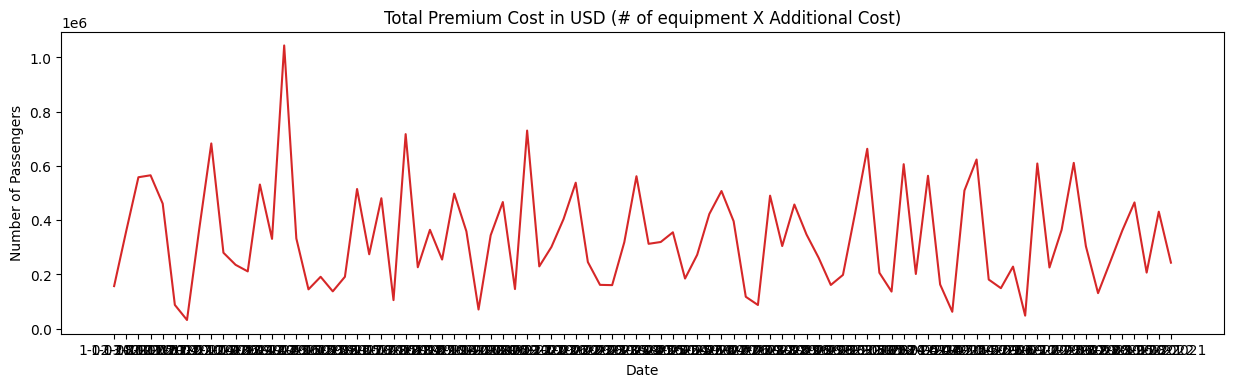

In [48]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(test_data, x=test_data['Date'], y=test_data['Total Premium Cost in USD (# of equipment X Additional Cost)'], title='Total Premium Cost in USD (# of equipment X Additional Cost)')

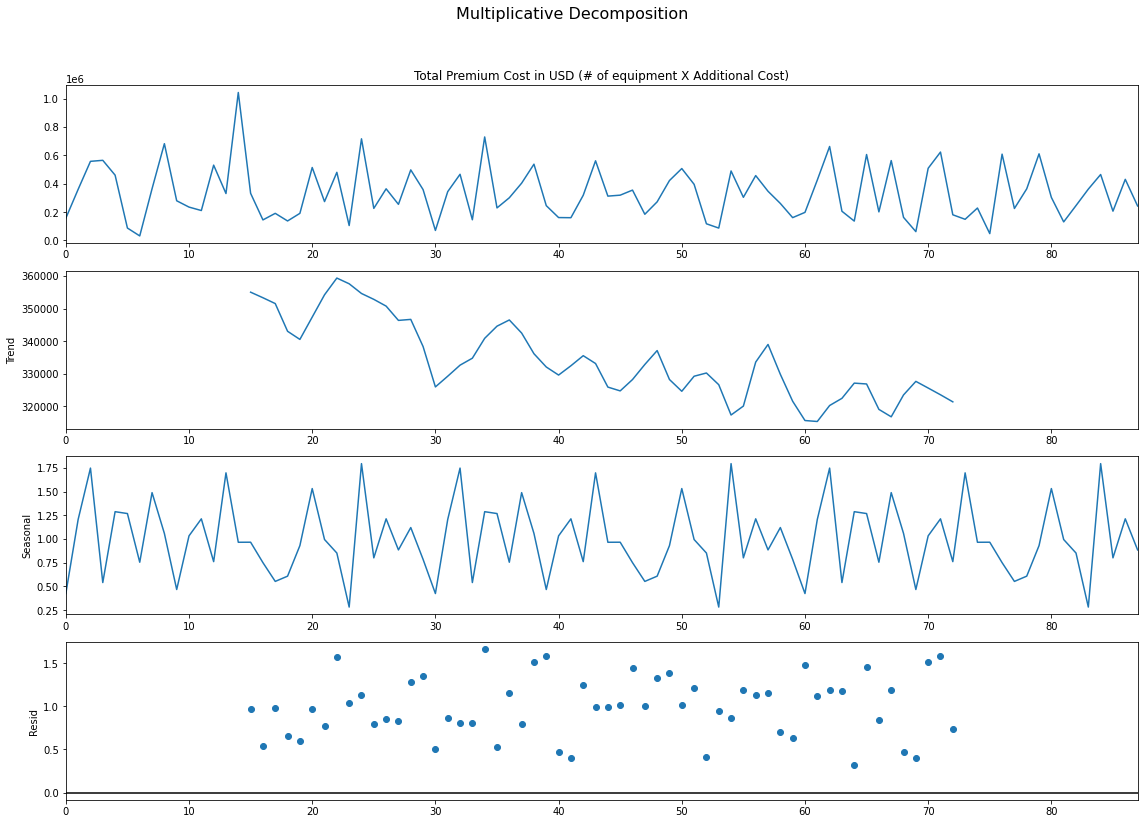

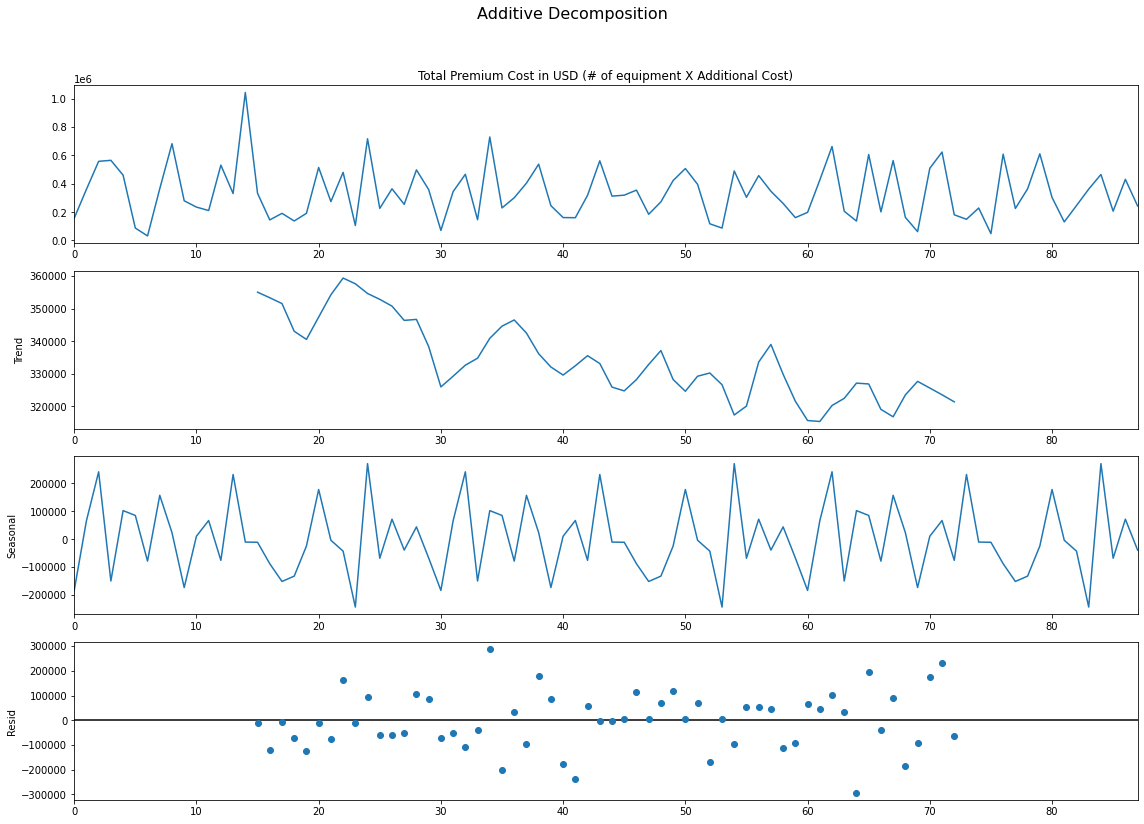

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(test_data['Total Premium Cost in USD (# of equipment X Additional Cost)'], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(test_data['Total Premium Cost in USD (# of equipment X Additional Cost)'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### Augmented Dickey Fuller test (ADF Test) for stationarity

In [53]:
from statsmodels.tsa.stattools import adfuller
adfuller(test_data['Total Premium Cost in USD (# of equipment X Additional Cost)'])

(-7.78922535666848,
 8.025013250838261e-12,
 3,
 84,
 {'1%': -3.510711795769895,
  '5%': -2.8966159448223734,
  '10%': -2.5854823866213152},
 2030.4145496033327)

#### Here’s how to interpret the most important values in the output:

#### Test statistic: -0.97538
#### P-value: 0.7621

#### Since the p-value is less than .05, we reject the null hypothesis. This means the time series is stationary. In other words, it has a non time-dependent structure and does have constant variance over time.

Text(0.5, 1.0, 'Total Premium Cost in USD (# of equipment X Additional Cost)')

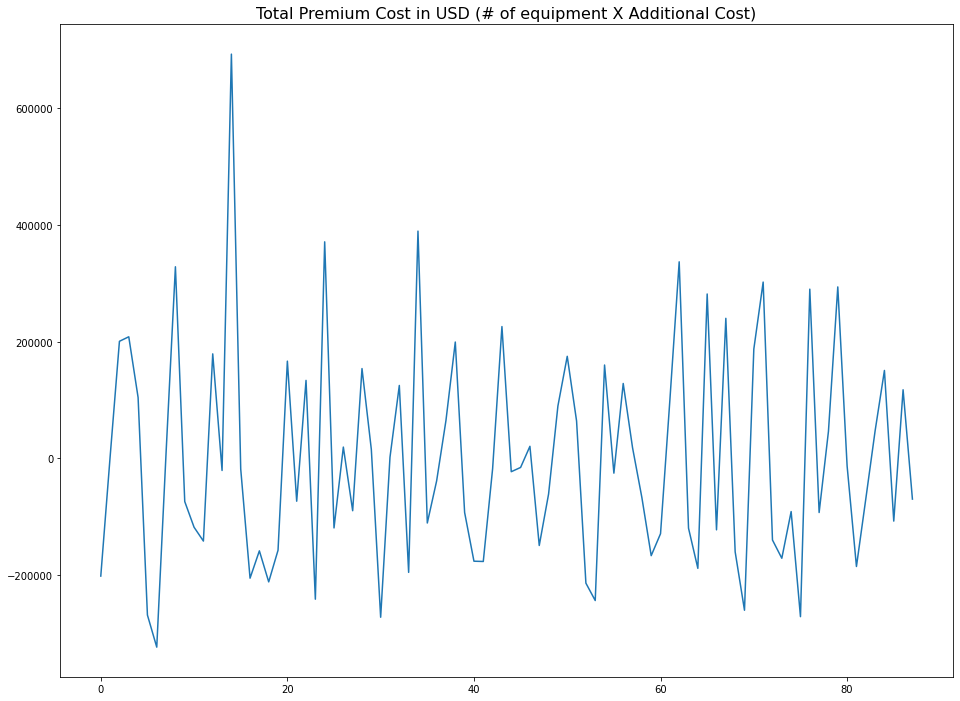

In [54]:
# Detrending

from scipy import signal
detrended = signal.detrend(test_data['Total Premium Cost in USD (# of equipment X Additional Cost)'].values)
plt.plot(detrended)
plt.title('Total Premium Cost in USD (# of equipment X Additional Cost)', fontsize=16)

Text(0.5, 1.0, 'Total Premium Cost detrended by subtracting the trend component')

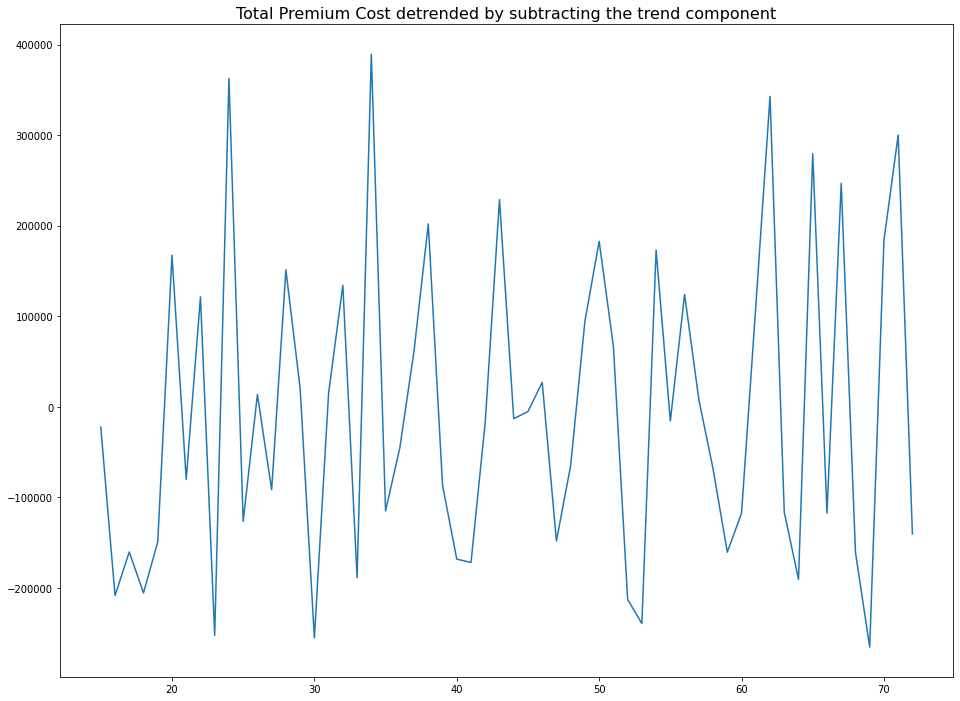

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(test_data['Total Premium Cost in USD (# of equipment X Additional Cost)'], model='multiplicative', period=30)
detrended = test_data['Total Premium Cost in USD (# of equipment X Additional Cost)'].values - result_mul.trend
plt.plot(detrended)
plt.title('Total Premium Cost detrended by subtracting the trend component', fontsize=16)